In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
%reload_ext autoreload

In [3]:
# Standart Libraries

import numpy as np

# Import files

import utilities
from Filter import ExtendedKalmanFilter
from Radar import Radar
from RadarSystem import RadarSystem
from Earth import Earth
from Satellite import Satellite
from SatelliteState import SatelliteState

from config import config


In [4]:
# Initialize Earth
earth = Earth()


# Initialize RadarSystem
# Beijing Aerospace Command and Control Center

BACC =  RadarSystem(Earth(), 300)


# Initialize Satellite
#R = config['satellite']['initial_conditions']['distance']
R = 6378136 + 200e3
theta = config['satellite']['initial_conditions']['polar_angle']
phi = config['satellite']['initial_conditions']['azimuthal_angle']

#phi = config['satellite']['initial_conditions']['polar_angle']
#theta = config['satellite']['initial_conditions']['azimuthal_angle']


#angular_vel = 0.0010830807404
#angular_vel = 0.0011313
angular_vel = 0.00118335995
tang_vel = angular_vel * R
radial_velocity = 0
azimuthal_velocity = 0


sat_state = SatelliteState(np.array([R, theta, phi]), np.array([0]), np.array([radial_velocity, tang_vel, azimuthal_velocity]), np.array([0]))
tiangong = Satellite(sat_state, 0, earth=earth)

In [5]:
list_position = np.array([radar.position for radar in BACC.radars])

In [6]:
# Initialize the Kalman Filter
# tianhe is the chinese super computer

#mean_0 = np.array([earth.re+380000, 0, 0.1, np.pi/2, angular_vel, 0])
r_noise = config['radar']['noise']['rho']
t_noise = config['radar']['noise']['theta']
mean_0 = np.array([R + 10e3, 0, 0.1, np.pi/2 - 0.05 , 0.001, 0])

# cov_0 = np.array([
#     [3.98e8, 0, 0, 0, 0, 0],
#     [0, 1.092e1, 0, 0, 0, 0],
#     [0, 0, 1e0, 0, 0, 0],
#     [0, 0, 0, 1.9533, 0, 0],
#     [0, 0, 0, 0, 5.194e-1, 0],
#     [0, 0, 0, 0, 0, 8.03e-2]
# ])

cov_0 = np.array([
    [1e4, 0, 0, 0, 0, 0],
    [0, 1e1, 0, 0, 0, 0],
    [0, 0, 1e0, 0, 0, 0],
    [0, 0, 0, 1e1, 0, 0],
    [0, 0, 0, 0, 1e0, 0],
    [0, 0, 0, 0, 0, 2e-2]
])

observation_noise = np.array([[2e2, 0],
              [0, 1e-1]])

Q = np.array([
    [100, 0, 0, 0, 0, 0],
    [0, 10, 0, 0, 0, 0],
    [0, 0, 0.1, 0, 0, 0],
    [0, 0, 0, 0.2, 0, 0],
    [0, 0, 0, 0, 0.02, 0],
    [0, 0, 0, 0, 0, 0.005]
])

tianhe = ExtendedKalmanFilter(mean_0, cov_0, earth, observation_noise=observation_noise, process_noise=Q)


In [7]:
n = 100000
simulation = tiangong.simulate(n)

sim_lenght = len(simulation.y[0])


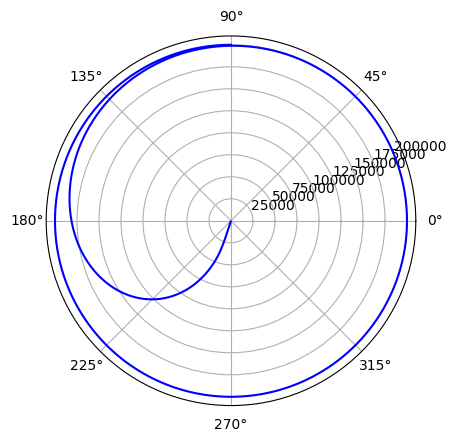

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

#n=np.argmin(np.abs(sol.y[0]-earth_radius))

R = simulation.y[0][:]-6378136.6
rad = simulation.y[2][:]
Phi = [np.pi/2 for i in rad]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='b')

plt.show()

In [9]:
from copy import deepcopy

In [10]:
m = deepcopy(mean_0)

In [11]:
m = np.array([m[0], m[3]])

In [12]:
predicted_states_satellite_cord = [m]
radar_states_satellite_cord = [m]

In [13]:
revolution = 0
loop = False
for i in range(int(sim_lenght)):
    
    if i < sim_lenght:
        current_state_satellite_cord = tiangong.get_position_at_t(i)
        current_state_earth_cord = utilities.spherical_to_spherical(current_state_satellite_cord)
        #current_state_earth_cord = current_state_satellite_cord
        noise_states_earth_cord = BACC.try_detect_satellite(current_state_earth_cord, i)

        if len(noise_states_earth_cord) > 0:
            print(len(noise_states_earth_cord))
            #print("Enter")
            flag = 0
            for state_earth_cord in noise_states_earth_cord:
                #state_satellite_cord = np.array([0,0,0])
                state_satellite_cord = utilities.earth_to_orbit(state_earth_cord.pos)

                #tracks the number of times the satellite has passed the radian axis and adjusts angle accordingly
                #essentially the radars being like you passed me twice here have 2 lots of 2pi
                if state_satellite_cord[1] < np.pi/4:
                    state_satellite_cord[1] += 2*np.pi*(revolution + 1)
                    loop = True
                elif loop == True and state_satellite_cord[1] >= np.pi/4:
                    revolution += 1
                    state_satellite_cord[1] += 2*np.pi*revolution
                    loop = False
                else:
                    state_satellite_cord[1] += 2*np.pi*revolution
                #state_satellite_cord = state_earth_cord.pos
                
                new_state_satellite_cord = tianhe.update(state_satellite_cord)

                if flag == 0:
                    #print(state_satellite_cord)
                    radar_states_satellite_cord += state_satellite_cord,
                    flag = 1
            
    forecast = tianhe.forecast()
    new_state_satellite_cord = [forecast[0][0][0], forecast[0][3][0]]

    predicted_states_satellite_cord += new_state_satellite_cord,

    #if earth.distance_to_surface(utilities.spherical_to_spherical(np.array([forecast[0][0][0], forecast[0][3][0], config['satellite']['initial_conditions']['azimuthal_angle']])))['inside']:
        #break




5
4
4
4
4
4
4
3
1
1
2
2
2
3
3
3
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
4
4
4
6
6
6
6
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
5
5
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
3
4
4
4
4
5
5
5
4
4
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
6
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
9
9
10
11
11
14
13
13
13
13
14
16
17
18
18
18
18
20
21
22
22
25
26
26
26
25
24
24
26
26
26
26
26
26
25
25
25
26
28
28
29
31
30
31
30
31
33
33
33
33
34
34
35
35
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
32
32
31
30
30
30
29
29
29
27
26
26
26
26
23
22
22
21
21
19
19
17
17
16
12
11
10
9
9
9
8
6
7
7
8
7
6
5
5
4
3
3
3
3
4
4
3
4
4
4
4
4
4
4
5
5
5
5
5
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4


KeyboardInterrupt



In [241]:
print(predicted_states_satellite_cord[-1])
R2, rad2 = np.array(predicted_states_satellite_cord[:]).T
R2 = R2 - 6378136.6
Phi = [np.pi/2 - config['satellite']['initial_conditions']['polar_angle'] for i in rad]

[6378403.179462778, 10.681266553395814]


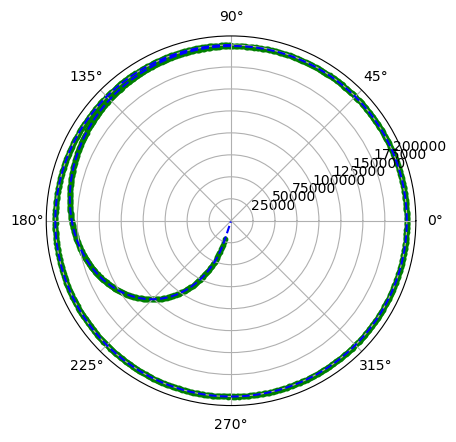

7741


In [242]:
radar_states_satellite_cord

R3, rad3 = np.array(radar_states_satellite_cord[1:]).T
R3 = R3 - 6378136.6

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

colors = plt.cm.rainbow(np.linspace(0, 1, len(R2[:3988])))

ax.plot(rad, R, c='b', linestyle="dashed",)
ax.scatter(rad3, R3, c='g', s = 10)

plt.show()

print(len(R2))

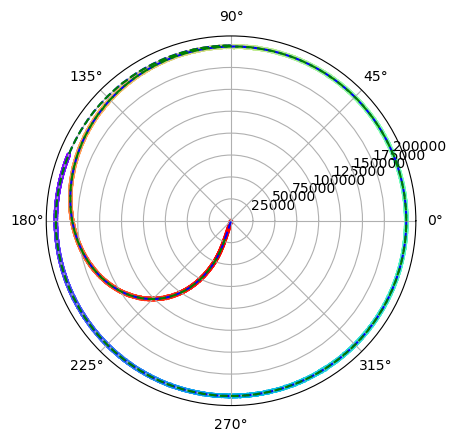

10.68188732265083 862.5138571280986
10.681266553395814 266.57946277875453


In [243]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
D = len(R2) 
O = 1000
colors = plt.cm.rainbow(np.linspace(0, 1, len(R2[O:D])))

ax.plot(rad, R, c='b', linestyle="dashed")
ax.scatter(rad2[O:D], R2[O:D], c=colors, s=5)
ax.plot(rad3, R3, c='g', linestyle="dashed")

plt.show()
print(rad[-1], R[-1])
print(rad2[-1], R2[-1])

In [244]:
R2, rad2 = np.array(predicted_states_satellite_cord[:]).T
trd = [np.pi/2 - theta]*len(R2)

In [245]:
predicted_states_earth_cord = np.array([utilities.spherical_to_spherical(np.array([R2,rad2,trd]).T[i]) for i in range(len(predicted_states_satellite_cord))])

In [246]:
x, y, z = utilities.earth_to_xyz_bulk(predicted_states_earth_cord).T

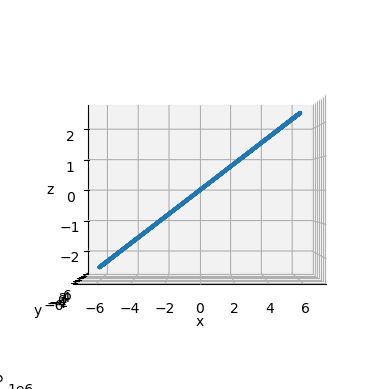

In [247]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.scatter(x, y, z, s = 3)


ax.view_init(0, -90)
ax.set_xlim([-7e6, 7e6])
ax.set_ylim([-7e6, 7e6])

ax.set(xlabel = 'x', ylabel = 'y', zlabel = 'z')

plt.show()

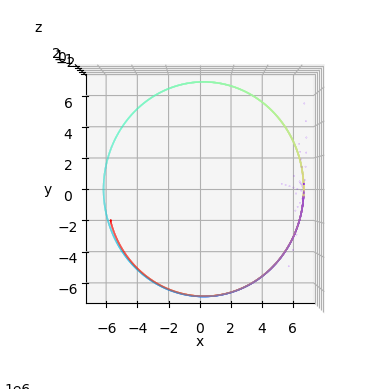

In [248]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

colors = plt.cm.rainbow(np.linspace(0, 1, len(x)))

plot = ax.scatter(x, y, z, c=colors, s = 0.01)

ax.view_init(90, -90)
ax.set_xlim([-7e6, 7e6])
ax.set_ylim([-7e6, 7e6])

ax.set(xlabel = 'x', ylabel = 'y', zlabel = 'z')

plt.show()

In [252]:
from main import Main
import matplotlib.pyplot as plt
import numpy as np
from config import config
import utilities

In [253]:
main = Main(200)

In [254]:
main.simulate()

In [ ]:
main.predict()

In [ ]:
R, rad, R2, rad2, R3, rad3 = main.output() # True, predicted, radar

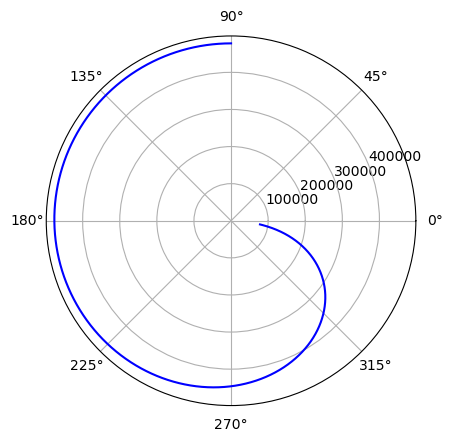

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R-6300000, c='b')

plt.show()

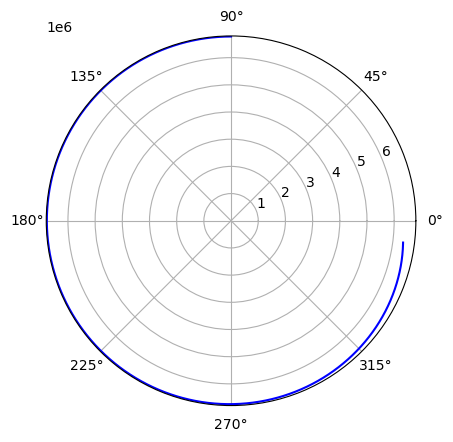

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='b')

plt.show()

In [ ]:
trd = [np.pi/2 - config['satellite']['initial_conditions']['polar_angle']]*len(R)

In [ ]:
predicted_states_earth_cord = np.array([utilities.spherical_to_spherical(np.array([R,rad,trd]).T[i]) for i in range(len(R))])

In [ ]:
x, y, z = utilities.earth_to_xyz_bulk(predicted_states_earth_cord).T

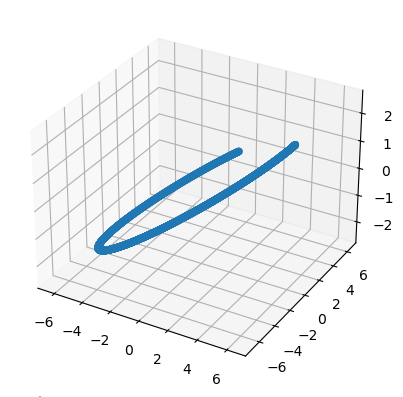

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.scatter(x, y, z)

plt.show()

In [ ]:
[main.BACC.radars[i].position

array([6.35718287e+06, 2.99879573e+00, 2.45855672e+00])

In [ ]:
main.BACC.radars

In [1]:
a = 0

In [2]:
'config_' + str(a) + '.json'

'config_0.json'

In [17]:
a = -np.NaN

In [18]:
arr = np.array([1,a,0])

In [19]:
c = utilities.p_to_c(arr)
j = 2+2

In [20]:
j

4

In [21]:
c

array([nan, nan, nan])